<a href="https://colab.research.google.com/github/natdebandi/hate_speech_ar/blob/main/3_train_GPT_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP final - reconocimiento de discursos discriminatorios en Twitter
## (3) Entrenamiento y finetuning de modelos GPT para clasificación

**Natalia Dedandi**

Se quiere entrenar un modelo GPT para clasificación de discursos de odio.

Para ello se quiere adaptar la forma en que se trabaja porque GPT esta entrenado para completar o responder un texto, por lo tanto queremos que esa respuesta sea binaria: odioso  no odioso.



La documentación de la API se encuentra aqui:

https://platform.openai.com/docs/api-reference/introduction

Este articulo contiene algunos detalles interesantes para los parámetros

https://jerichosiahaya.medium.com/openai-gpts-chat-completion-api-parameters-101-d074b23027ce


La nueva API de GPT modificó la forma de acceder para pasar de completar a chat. Sin embargo se puede obtener el mismo resultado. Documentación sobre ello está aqui:

https://help.openai.com/en/articles/7042661-moving-from-completions-to-chat-completions-in-the-openai-api


Guia para finetuning:

https://medium.com/@garethcull/fine-tuning-ai-models-a-practical-guide-for-beginners-dc313b2e0f76

In [4]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.8/328.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00


In [5]:
!pip install datasets seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [6]:
import json
from openai import OpenAI
import os
from google.colab import userdata
#seteo la KEY
os.environ['OPENAI_API_KEY'] = userdata.get('openIA_key')




In [7]:
#creo el cliente OPENAI con mi usuario y proyecto
client = OpenAI(
  organization='org-1uHjwiaB3OlPzoxfVzhqOSzs',
  project='proj_2fII7izwVGgYaERNNKhhMx4l',
)

Creo una función para que GPT 4 determine si es odioso o no el TW

Basado en este ejemplo:
https://community.openai.com/t/i-am-facing-issue-in-running-sentiment-analysis-api-with-openai-while-i-have-fullfilled-all-the-basic-code-which-i-got-from-google-bard/570554


In [8]:

def sentiment_analysis(text):

    # Call the OpenAI API to generate a response
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are trained to analyze and detect the sentiment of the given text. Only hateful or not hateful is needed. The answer should be in spanish"},
            {"role": "user", "content": text}
        ],
        max_tokens=20,  # Limit response to a single word
        temperature=0  # Keep response consistent
    )

    # Extract the sentiment from the response
    sentiment = response.choices[0].message.content.strip().lower()

    return sentiment

# Example usage
input_text = "Las personas chinas son todas sucias"
sentiment = sentiment_analysis(input_text)
print(input_text, "Sentiment is:", sentiment)



Las personas chinas son todas sucias Sentiment is: odioso


In [9]:
input_text = "Que bello dia es hoy"
sentiment = sentiment_analysis(input_text)
print(input_text, "Sentiment is:", sentiment)

Que bello dia es hoy Sentiment is: no odioso


Aplico el setiment analysis con GPT a un extracto de mis datos para ver como sale

In [10]:
from datasets import load_dataset
import pandas as pd

ds1 = load_dataset("piuba-bigdata/contextualized_hate_speech")

df_train_sample = pd.DataFrame(ds1['train'].select_columns(["text","HATEFUL"]))
df_train_sample= df_train_sample.sample(n=50, random_state=0)
df_train_sample

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/36420 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11343 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/9106 [00:00<?, ? examples/s]

,text,HATEFUL
24752,@usuario En toda desgracia siempre hay benefic...,0
3004,@usuario Hay q ser especialista para poder dar...,0
29851,@usuario Puede hablar el gordo drogadicto toda...,1
21119,@usuario Medios de mierda deja de vender humo ...,0
26686,"@usuario A ver, Tinelli se cago en la cuarente...",0
21746,"@usuario quehijadeputa, que hecha mierda está!!!!",0
9224,@usuario La entrevista esta mas arreglada que ...,0
13539,"@usuario Cual es el problema, ahora las aborte...",1
21460,@usuario @usuario Putin no te puede arrimar al...,0
28452,@usuario @usuario Le creo tan poco a los Chino...,0


Habria que limpiar los textos. Aqui un ejemplo:
https://github.com/alvaroruizp/spanish-twitter-sentiment-analyzer/blob/main/Building%20a%20Twitter%20sentiment%20analyzer.ipynb

Al ver algunos TW tal vez agregarle en GPT el TW orignal de contexto podría mejorar mucho la detección, sin necesidad de hacer finetuning.

In [12]:
#import numpy as np
# Applying the condition using apply and lambda
#df_train_sample['completion'] = df_train_sample['completion'].apply(lambda x: 'Hateful' if x == 1 else 'neutral')


In [11]:

def apply_sentiment(df, text_column='text', sentiment_column='sentiment'):
    """
    Applies the sentiment function to each row of the DataFrame and adds the result in a new column.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    text_column (str): The column name that contains the text data.
    sentiment_column (str): The column name to store the sentiment results.

    Returns:
    pd.DataFrame: The dataframe with the new sentiment column.
    """
    df[sentiment_column] = df[text_column].apply(sentiment)
    return df

In [13]:


 df_train_sample['sentiment_column'] = df_train_sample['text'].apply(sentiment_analysis)

 #df_sentiment= apply_sentiment(df_train_sample, text_column='text', sentiment_column='sentiment')


In [14]:
df_train_sample

,text,HATEFUL,sentiment_column
24752,@usuario En toda desgracia siempre hay benefic...,0,no odioso
3004,@usuario Hay q ser especialista para poder dar...,0,no odioso
29851,@usuario Puede hablar el gordo drogadicto toda...,1,odioso
21119,@usuario Medios de mierda deja de vender humo ...,0,odioso
26686,"@usuario A ver, Tinelli se cago en la cuarente...",0,no odioso
21746,"@usuario quehijadeputa, que hecha mierda está!!!!",0,odioso
9224,@usuario La entrevista esta mas arreglada que ...,0,no odioso
13539,"@usuario Cual es el problema, ahora las aborte...",1,odioso
21460,@usuario @usuario Putin no te puede arrimar al...,0,no odioso.
28452,@usuario @usuario Le creo tan poco a los Chino...,0,no odioso


<ipython-input-15-a1f11f152fe3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_train_sample, x='HATEFUL', y='sentiment_column', inner='stick', palette='Dark2')


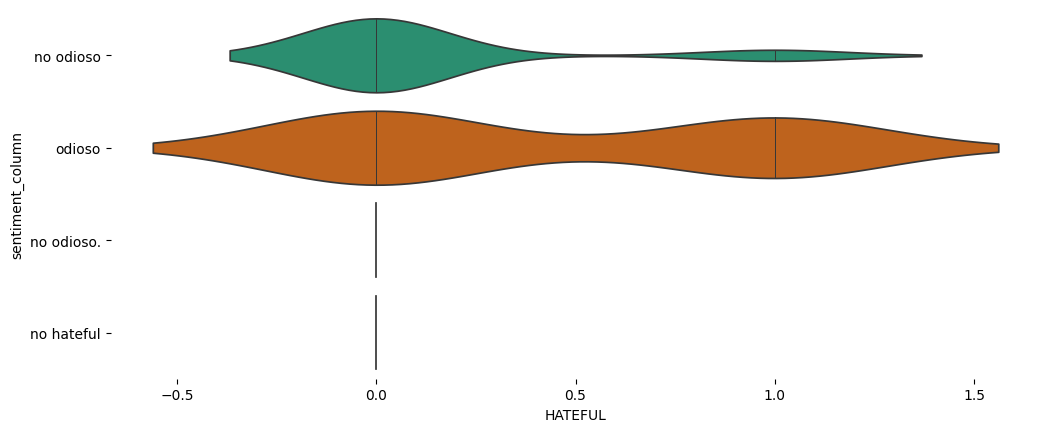

In [15]:
# @title sentiment_column vs HATEFUL

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_train_sample['sentiment_column'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_train_sample, x='HATEFUL', y='sentiment_column', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)